## 4-Dimensional Data Visualization: Time in Bubble Charts

> Bubble charts typically display 3 dimensions using x, y, and bubble size, but adding time as a 4th dimension can provide deeper insights.

Bubble charts elegantly compress large amounts of information into a single visualization, with bubble size adding a third dimension. However, comparing “before” and “after” states is often crucial.

Adding a time dimension to bubble charts enhances their ability to convey dynamic data changes intuitively. By implementing smooth transitions between “before” and “after” states, users can better understand trends and comparisons over time.

While no ready-made solutions were available, developing a custom approach proved both challenging and rewarding, requiring mathematical insights and careful animation techniques. The proposed method can be easily extended to various datasets, making it a valuable tool for data visualization in business, science, and analytics.

In [1]:
!pip install -U -q sympy --no-cache-dir --disable-pip-version-check

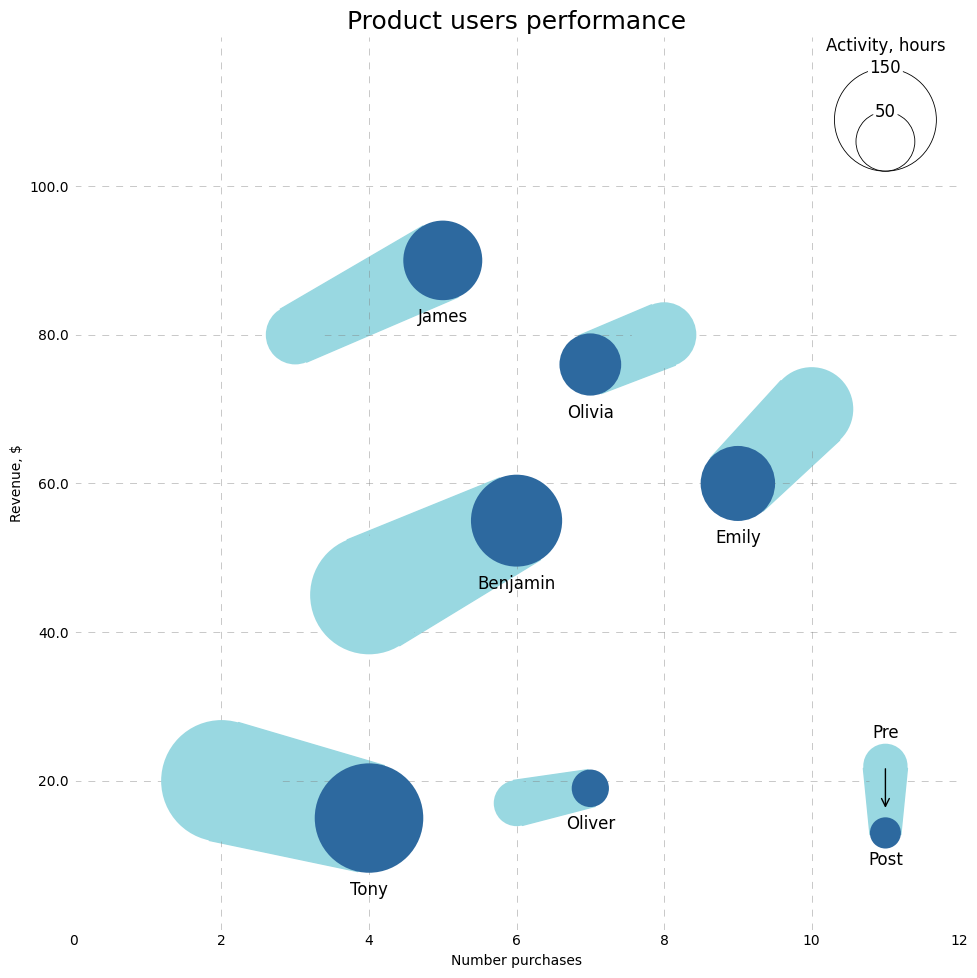

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from scipy.spatial import ConvexHull
import math
from matplotlib import rcParams
import matplotlib.patches as patches

import warnings
warnings.filterwarnings('ignore')

def check_position_relative_to_line(a, b, x0, y0):
    y_line = a * x0 + b
    
    if y0 > y_line:
        return 1 # line is above the point
    elif y0 < y_line:
        return -1

    
def find_tangent_equations(x1, y1, r1, x2, y2, r2):
    a, b = sp.symbols('a b')

    tangent_1 = (a*x1 + b - y1)**2 - r1**2 * (a**2 + 1)  
    tangent_2 = (a*x2 + b - y2)**2 - r2**2 * (a**2 + 1) 

    eqs_1 = [tangent_2, tangent_1]
    solution = sp.solve(eqs_1, (a, b))
    parameters = [(float(e[0]), float(e[1])) for e in solution]

    # filter just external tangents
    parameters_filtered = []
    for tangent in parameters:
        a = tangent[0]
        b = tangent[1]
        if abs(check_position_relative_to_line(a, b, x1, y1) + check_position_relative_to_line(a, b, x2, y2)) == 2:
            parameters_filtered.append(tangent)

    return parameters_filtered

def find_circle_line_intersection(circle_x, circle_y, circle_r, line_a, line_b):
    x, y = sp.symbols('x y')
    circle_eq = (x - circle_x)**2 + (y - circle_y)**2 - circle_r**2
    intersection_eq = circle_eq.subs(y, line_a * x + line_b)

    sol_x_raw = sp.solve(intersection_eq, x)[0]
    try:
        sol_x = float(sol_x_raw)
    except:
        sol_x = sol_x_raw.as_real_imag()[0]
    sol_y = line_a * sol_x + line_b
    return sol_x, sol_y

def draw_polygon(plt, points):
    hull = ConvexHull(points)
    convex_points = [points[i] for i in hull.vertices]

    x, y = zip(*convex_points)
    x += (x[0],)
    y += (y[0],)

    plt.fill(x, y, color='#99d8e1', alpha=1, zorder=1)

def area_to_radius(area):
    radius = math.sqrt(area / math.pi)
    return radius

# data generation
df = pd.DataFrame({'user': ['Emily', 'Emily', 'James', 'James', 'Tony', 'Tony', 'Olivia', 'Olivia', 'Oliver', 'Oliver', 'Benjamin', 'Benjamin'],
                   'period': ['pre', 'post', 'pre', 'post', 'pre', 'post', 'pre', 'post', 'pre', 'post', 'pre', 'post'],
                   'num_purchases': [10, 9, 3, 5, 2, 4, 8, 7, 6, 7, 4, 6],
                   'revenue': [70, 60, 80, 90, 20, 15, 80, 76, 17, 19, 45, 55],
                   'activity': [100, 80, 50, 90, 210, 170, 60, 55, 30, 20, 200, 120]})

x_alias, y_alias, a_alias = 'num_purchases', 'revenue', 'activity'

# scaling metrics
radius_scaler = 0.1
df['radius'] = df[a_alias].apply(area_to_radius) * radius_scaler
df['y_scaled'] = df[y_alias] / df[x_alias].max()

# plot parameters
plt.subplots(figsize=(10, 10))
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 14
plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6, zorder=1)
plt.axvline(x=0, color='white', linewidth=2)
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# spines formatting
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().tick_params(axis="both", which="both", length=0)

# plot labels
plt.xlabel("Number purchases") 
plt.ylabel("Revenue, $")
plt.title("Product users performance", fontsize=18, color="black")

# axis limits
axis_lim = df[x_alias].max() * 1.2
plt.xlim(0, axis_lim)
plt.ylim(0, axis_lim)

# bubble pre
for _, row in df[df.period=='pre'].iterrows():
    x = row[x_alias]
    y = row.y_scaled
    r = row.radius
    circle = patches.Circle((x, y), r, facecolor='#99d8e1', edgecolor='none', linewidth=0, zorder=2)
    plt.gca().add_patch(circle)

# transition area
for user in df.user.unique():
    user_pre = df[(df.user==user) & (df.period=='pre')]
    x1, y1, r1 = user_pre[x_alias].values[0], user_pre.y_scaled.values[0], user_pre.radius.values[0]
    user_post = df[(df.user==user) & (df.period=='post')]
    x2, y2, r2 = user_post[x_alias].values[0], user_post.y_scaled.values[0], user_post.radius.values[0]

    tangent_equations = find_tangent_equations(x1, y1, r1, x2, y2, r2)
    circle_1_line_intersections = [find_circle_line_intersection(x1, y1, r1, eq[0], eq[1]) for eq in tangent_equations]
    circle_2_line_intersections = [find_circle_line_intersection(x2, y2, r2, eq[0], eq[1]) for eq in tangent_equations]

    polygon_points = circle_1_line_intersections + circle_2_line_intersections
    draw_polygon(plt, polygon_points)

# bubble post
for _, row in df[df.period=='post'].iterrows():
    x = row[x_alias]
    y = row.y_scaled
    r = row.radius
    label = row.user
    circle = patches.Circle((x, y), r, facecolor='#2d699f', edgecolor='none', linewidth=0, zorder=2)
    plt.gca().add_patch(circle)

    plt.text(x, y - r - 0.3, label, fontsize=12, ha='center')

# bubble size legend
legend_areas_original = [150, 50]
legend_position = (11, 10.2)
for i in legend_areas_original:
    i_r = area_to_radius(i) * radius_scaler
    circle = plt.Circle((legend_position[0], legend_position[1] + i_r), i_r, color='black', fill=False, linewidth=0.6, facecolor='none')
    plt.gca().add_patch(circle)
    plt.text(legend_position[0], legend_position[1] + 2*i_r, str(i), fontsize=12, ha='center', va='center',
              bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1'))
legend_label_r = area_to_radius(np.max(legend_areas_original)) * radius_scaler
plt.text(legend_position[0], legend_position[1] + 2*legend_label_r + 0.3, 'Activity, hours', fontsize=12, ha='center', va='center')


## pre-post legend 
# circle 1
legend_position, r1 = (11, 2.2), 0.3
x1, y1 = legend_position[0], legend_position[1]
circle = patches.Circle((x1, y1), r1, facecolor='#99d8e1', edgecolor='none', linewidth=0, zorder=2)
plt.gca().add_patch(circle)
plt.text(x1, y1 + r1 + 0.15, 'Pre', fontsize=12, ha='center', va='center')
# circle 2
x2, y2 = legend_position[0], legend_position[1] - r1*3
r2 = r1*0.7
circle = patches.Circle((x2, y2), r2, facecolor='#2d699f', edgecolor='none', linewidth=0, zorder=2)
plt.gca().add_patch(circle)
plt.text(x2, y2 - r2 - 0.15, 'Post', fontsize=12, ha='center', va='center')
# tangents
tangent_equations = find_tangent_equations(x1, y1, r1, x2, y2, r2)
circle_1_line_intersections = [find_circle_line_intersection(x1, y1, r1, eq[0], eq[1]) for eq in tangent_equations]
circle_2_line_intersections = [find_circle_line_intersection(x2, y2, r2, eq[0], eq[1]) for eq in tangent_equations]
polygon_points = circle_1_line_intersections + circle_2_line_intersections
draw_polygon(plt, polygon_points)
# small arrow
plt.annotate('', xytext=(x1, y1), xy=(x2, y1 - r1*2), arrowprops=dict(edgecolor='black', arrowstyle='->', lw=1))

# y axis formatting
max_y = df[y_alias].max()
nearest_power_of_10 = 10 ** math.ceil(math.log10(max_y))
ticks = [round(nearest_power_of_10/5 * i, 2) for i in range(0, 6)]
yticks_scaled = ticks / df[x_alias].max()
yticklabels = [str(i) for i in ticks]
yticklabels[0] = ''
plt.yticks(yticks_scaled, yticklabels)

plt.tight_layout()
plt.show()
## plt.savefig("plot_with_white_background.png", bbox_inches='tight', dpi=300)